## Can we predict which job categories will become more in demand per season based on historical data?

In [2]:
# Load in data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

os.chdir("C:/Users/veldh/PycharmProjects/CBS_Project")
print("Directory after change", os.getcwd())

CBS_data = pd.read_csv("80474ned_TypedDataSet_27112023_151242.csv", sep=';')

Directory after change C:\Users\veldh\PycharmProjects\CBS_Project


In [3]:
# Look at SBI codes
unique_values = CBS_data["SBI2008PartBedrijvenOverheid"].unique()
print(unique_values)

# Organize df
CBS_dataframe = pd.DataFrame(CBS_data)

CBS_dataframe.rename(
    columns={"SBI2008PartBedrijvenOverheid": "SBI", "VacaturesSeizoengecorrigeerd_1": "Vacatures"},
    inplace=True
)

CBS_dataframe["SBI"] = CBS_dataframe["SBI"].str.strip()
CBS_dataframe["SBI"] = CBS_dataframe["SBI"].astype(str)
print(CBS_dataframe.head())

['T001081' '301000 ' '300003 ' '300007 ' '300010 ' '300013 ' '307500 '
 '350000 ' '354200 ' '383100 ' '389100 ' '391600 ' '396300 ' '402000 '
 '403300 ' '410200 ' '417400 ' '419000 ' '422400 ' '428100 ' '435500 '
 '10610  ' '10601  ']
   ID      SBI  Perioden  Vacatures
0   0  T001081  1997KW01       83.8
1   1  T001081  1997KW02       86.2
2   2  T001081  1997KW03      107.6
3   3  T001081  1997KW04      122.9
4   4  T001081  1998KW01      128.0


In [4]:
# Transform Vacatures
CBS_dataframe["Vacatures"] = CBS_dataframe["Vacatures"] * 1000
CBS_dataframe["Log_Vacatures"] = np.log(CBS_dataframe["Vacatures"])

# 10601 is irrelevant and can be dropped from the dataframe
CBS_dataframe = CBS_dataframe[CBS_dataframe["SBI"] != "10601"]

# Replace SBI codes to something more readable
replacement_dict = {
    "T001081": "A-U Alle economische activiteiten",
    "301000": "A Landbouw, bosbouw en visserij",
    "300003": "B-F Nijverheid en energie",
    "300007": "G-N Commerciële dienstverlening",
    "300010": "M-N Zakelijke dienstverlening",
    "300013": "O-U Niet-commerciële dienstverlening",
    "307500": "C Industrie",
    "350000": "F Bouwnijverheid",
    "354200": "G Handel",
    "383100": "H Vervoer en opslag",
    "389100": "I Horeca",
    "391600": "J Informatie en communicatie",
    "396300": "K Financiële dienstverlening",
    "402000": "L Verhuur en handel van onroerend goed",
    "403300": "M Specialistische zakelijke diensten",
    "410200": "N Verhuur en overige zakelijke diensten",
    "417400": "O Openbaar bestuur en overheidsdiensten",
    "419000": "P Onderwijs",
    "422400": "Q Gezondheids- en welzijnszorg",
    "428100": "R Cultuur, sport en recreatie",
    "435500": "S Overige dienstverlening",
}

CBS_dataframe["SBI"].replace(replacement_dict, inplace=True)
print(CBS_dataframe["SBI"].unique())

['A-U Alle economische activiteiten' 'A Landbouw, bosbouw en visserij'
 'B-F Nijverheid en energie' 'G-N Commerciële dienstverlening'
 'M-N Zakelijke dienstverlening' 'O-U Niet-commerciële dienstverlening'
 'C Industrie' 'F Bouwnijverheid' 'G Handel' 'H Vervoer en opslag'
 'I Horeca' 'J Informatie en communicatie' 'K Financiële dienstverlening'
 'L Verhuur en handel van onroerend goed'
 'M Specialistische zakelijke diensten'
 'N Verhuur en overige zakelijke diensten'
 'O Openbaar bestuur en overheidsdiensten' 'P Onderwijs'
 'Q Gezondheids- en welzijnszorg' 'R Cultuur, sport en recreatie'
 'S Overige dienstverlening' '10610']


In [5]:
# Create dictionary for quartiles
quarter_to_months = {
    "KW01": "01",
    "KW02": "04",
    "KW03": "07",
    "KW04": "10"
}

# Create function that parses quarter strings to dates
def parse_quarter_string(quarter_string):
    year, quarter = quarter_string[:4], quarter_string[4:]
    return f"{year}-{quarter_to_months[quarter]}-01"

CBS_dataframe["Perioden"] = CBS_dataframe["Perioden"].apply(parse_quarter_string)
CBS_dataframe["Formatted_Perioden"] = pd.to_datetime(CBS_dataframe["Perioden"])

# Function that creates time features
def create_features(df):
    df.loc[:, "Hour"] = df["Formatted_Perioden"].dt.hour
    df.loc[:, "Day"] = df["Formatted_Perioden"].dt.day
    df.loc[:, "Month"] = df["Formatted_Perioden"].dt.month
    df.loc[:, "Quarter"] = df["Formatted_Perioden"].dt.quarter
    df.loc[:, "Year"] = df["Formatted_Perioden"].dt.year
    return df

In [6]:
# Create categories to iterate over
categories = [
'A-U Alle economische activiteiten', 'A Landbouw, bosbouw en visserij',
    'B-F Nijverheid en energie', 'G-N Commerciële dienstverlening',
    'M-N Zakelijke dienstverlening', 'O-U Niet-commerciële dienstverlening',
    'C Industrie', 'F Bouwnijverheid', 'G Handel', 'H Vervoer en opslag',
    'I Horeca', 'J Informatie en communicatie', 'K Financiële dienstverlening',
    'L Verhuur en handel van onroerend goed', 'M Specialistische zakelijke diensten',
    'N Verhuur en overige zakelijke diensten', 'O Openbaar bestuur en overheidsdiensten',
    'P Onderwijs', 'Q Gezondheids- en welzijnszorg', 'R Cultuur, sport en recreatie',
    'S Overige dienstverlening', 'Particuliere bedrijven'
]

# Loop over all categories from CBS_dataframe
category_dataframes = {}

for category in categories:
    temp_df = CBS_dataframe[CBS_dataframe["SBI"] == category].copy()
    temp_df = create_features(df=temp_df)
    # Split into training and test set
    train = temp_df[temp_df["Formatted_Perioden"] < "2018-01-01"]
    test = temp_df[temp_df["Formatted_Perioden"] >= "2018-01-01"]
    # Store the split dataframes in a dictionary for later access
    category_dataframes[category] = {'train': train, 'test': test}
    # category_df is now available to analyze each category separately
    
print(category_dataframes['Q Gezondheids- en welzijnszorg'])

{'train':         ID                             SBI    Perioden  Vacatures  \
1926  1926  Q Gezondheids- en welzijnszorg  1997-01-01     8500.0   
1927  1927  Q Gezondheids- en welzijnszorg  1997-04-01     8500.0   
1928  1928  Q Gezondheids- en welzijnszorg  1997-07-01    10000.0   
1929  1929  Q Gezondheids- en welzijnszorg  1997-10-01    11200.0   
1930  1930  Q Gezondheids- en welzijnszorg  1998-01-01    12500.0   
...    ...                             ...         ...        ...   
2005  2005  Q Gezondheids- en welzijnszorg  2016-10-01    24800.0   
2006  2006  Q Gezondheids- en welzijnszorg  2017-01-01    25800.0   
2007  2007  Q Gezondheids- en welzijnszorg  2017-04-01    26800.0   
2008  2008  Q Gezondheids- en welzijnszorg  2017-07-01    27900.0   
2009  2009  Q Gezondheids- en welzijnszorg  2017-10-01    29300.0   

      Log_Vacatures Formatted_Perioden  Hour  Day  Month  Quarter  Year  
1926       9.047821         1997-01-01     0    1      1        1  1997  
1927       9.

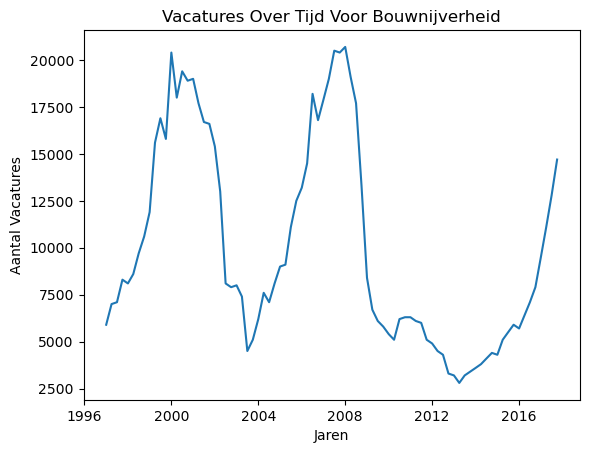

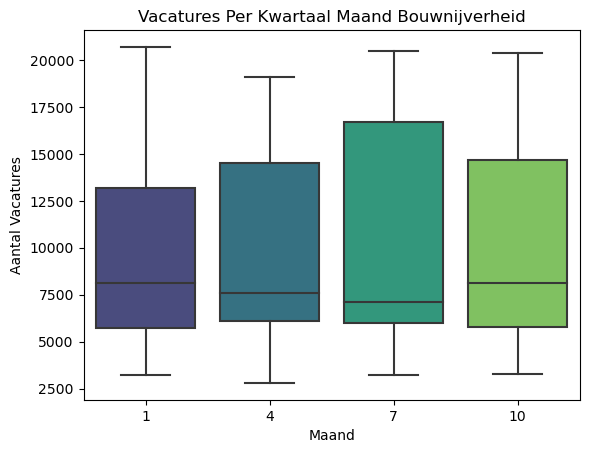

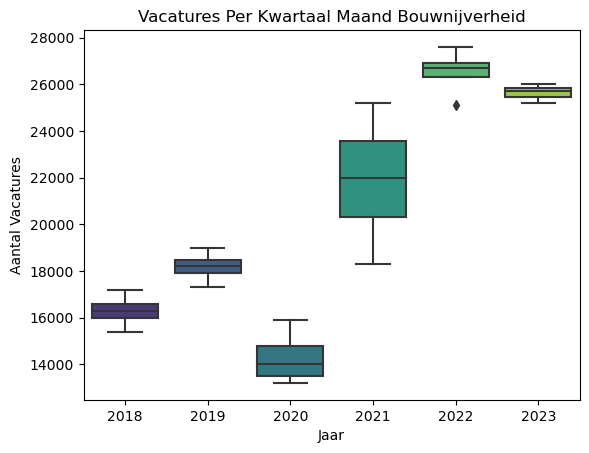

In [7]:
# Visualize
plot_category = category_dataframes["F Bouwnijverheid"]["train"]
plt.plot(plot_category["Formatted_Perioden"], plot_category["Vacatures"])
plt.title("Vacatures Over Tijd Voor Bouwnijverheid")
plt.xlabel("Jaren")
plt.ylabel("Aantal Vacatures")
plt.show()

sns.boxplot(data=plot_category, x="Month", y="Vacatures", palette="viridis")
plt.title("Vacatures Per Kwartaal Maand Bouwnijverheid")
plt.xlabel("Maand")
plt.ylabel("Aantal Vacatures")
plt.show()

plot_filtered = category_dataframes["F Bouwnijverheid"]["test"]
plot_filtered = plot_filtered[(plot_filtered["Year"] >= 2018) & (plot_filtered["Year"] <= 2023)]
sns.boxplot(data=plot_filtered, x="Year", y="Vacatures", palette="viridis")
plt.title("Vacatures Per Kwartaal Maand Bouwnijverheid")
plt.xlabel("Jaar")
plt.ylabel("Aantal Vacatures")
plt.show()

In [8]:
# Create model
features = ["Month", "Year"]
target = 'Vacatures'

models = {}

for category, data in category_dataframes.items():
    x_train = data['train'][features]
    x_test = data['test'][features]
    y_train = data['train'][target]
    y_test = data['test'][target]
    
    reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.1)
    reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)
    
    models[category] = reg

[0]	validation_0-rmse:42258.06479	validation_1-rmse:186654.77272
[100]	validation_0-rmse:1122.43506	validation_1-rmse:146503.29566
[200]	validation_0-rmse:158.38525	validation_1-rmse:146405.73192
[300]	validation_0-rmse:31.49574	validation_1-rmse:146400.57702
[393]	validation_0-rmse:6.05961	validation_1-rmse:146399.95579
[0]	validation_0-rmse:840.84400	validation_1-rmse:1035.38928
[50]	validation_0-rmse:91.24967	validation_1-rmse:1265.48203
[0]	validation_0-rmse:10283.43604	validation_1-rmse:26330.15484
[100]	validation_0-rmse:175.83100	validation_1-rmse:23377.27652
[200]	validation_0-rmse:21.84805	validation_1-rmse:23365.76672
[238]	validation_0-rmse:9.47429	validation_1-rmse:23365.63996
[0]	validation_0-rmse:24844.92236	validation_1-rmse:110325.82824
[100]	validation_0-rmse:1058.59225	validation_1-rmse:83386.31595
[200]	validation_0-rmse:151.60943	validation_1-rmse:83316.35884
[300]	validation_0-rmse:24.87961	validation_1-rmse:83314.83857
[306]	validation_0-rmse:22.07660	validation_1

C:\Users\veldh\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


In [9]:
importance_df = {}

for category, model in models.items():
    df = pd.DataFrame(data=model.feature_importances_,
                index=features,
                columns=['Importance'])
    df = df.sort_values(by='Importance', ascending=False)
    importance_df[category] = df

In [10]:
for category in categories:
    print(f"Feature Importances for {category}:")
    if category in importance_df:
        print(importance_df[category])
    else:
        print(f"No data available for {category}.")
    print("\n" + "-"*50 + "\n")

Feature Importances for A-U Alle economische activiteiten:
       Importance
Year     0.949059
Month    0.050941

--------------------------------------------------

Feature Importances for A Landbouw, bosbouw en visserij:
       Importance
Year     0.956194
Month    0.043806

--------------------------------------------------

Feature Importances for B-F Nijverheid en energie:
       Importance
Year     0.949708
Month    0.050292

--------------------------------------------------

Feature Importances for G-N Commerciële dienstverlening:
       Importance
Year     0.938833
Month    0.061167

--------------------------------------------------

Feature Importances for M-N Zakelijke dienstverlening:
       Importance
Year     0.936635
Month    0.063365

--------------------------------------------------

Feature Importances for O-U Niet-commerciële dienstverlening:
       Importance
Year     0.961578
Month    0.038422

--------------------------------------------------

Feature Importanc

### Run on test set

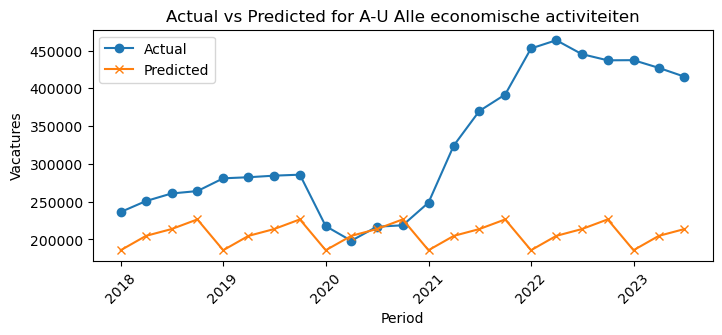

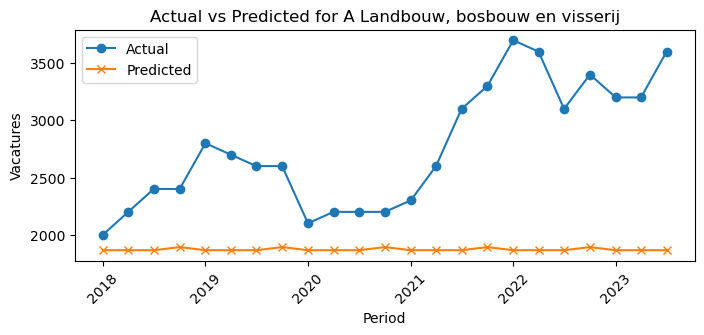

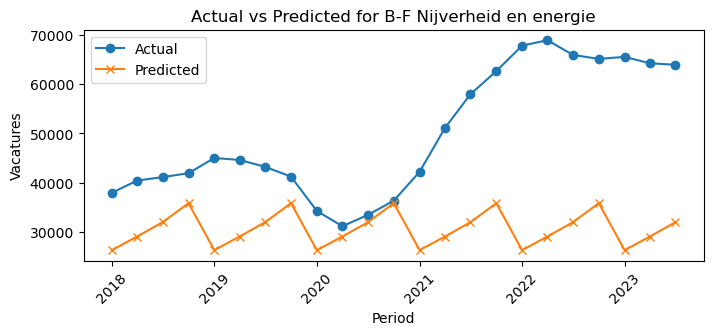

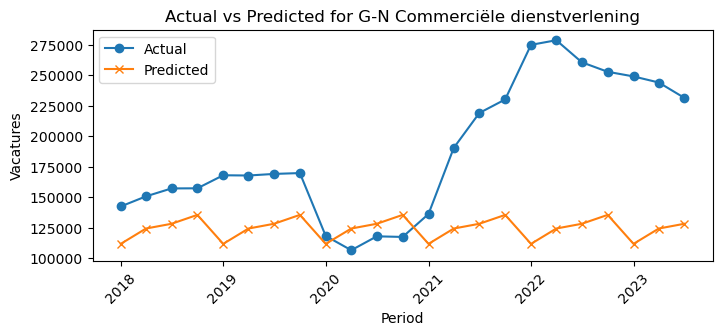

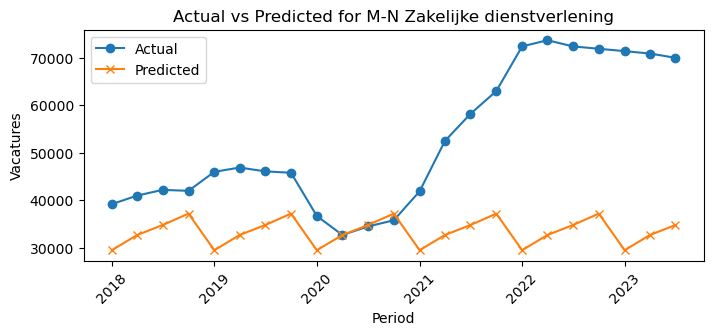

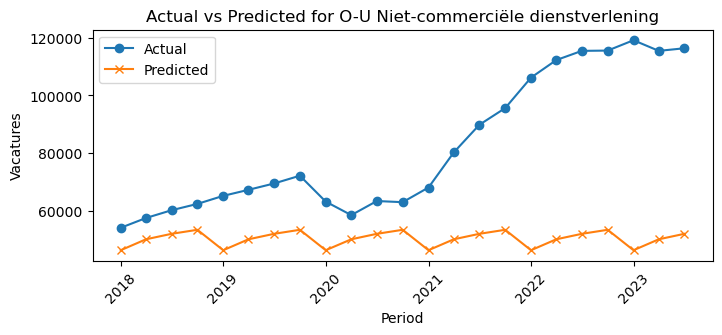

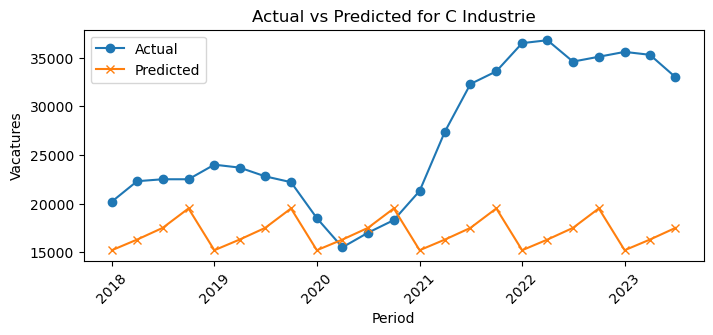

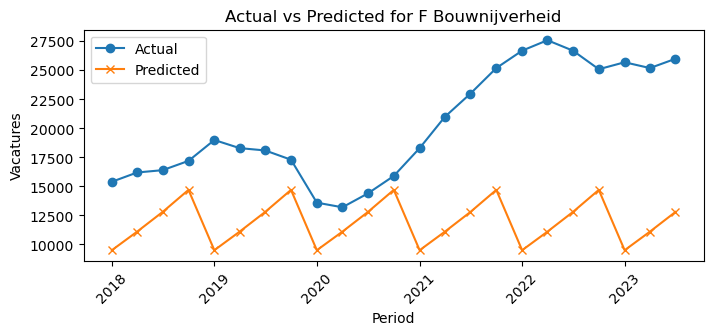

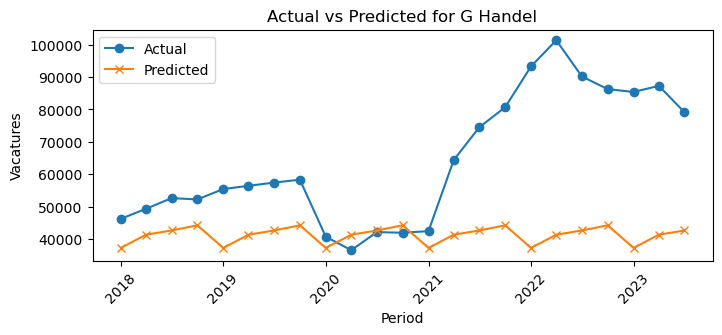

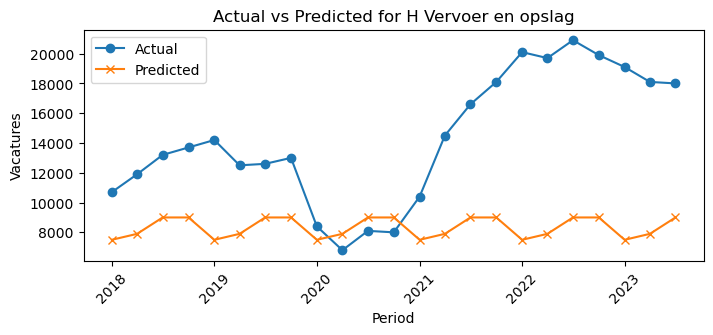

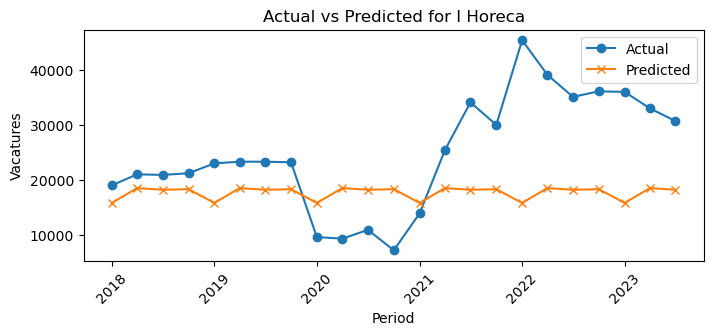

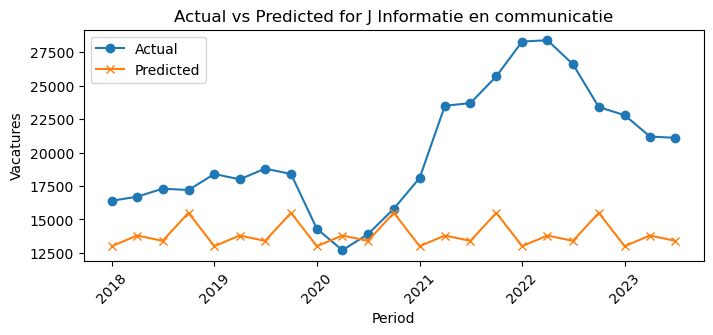

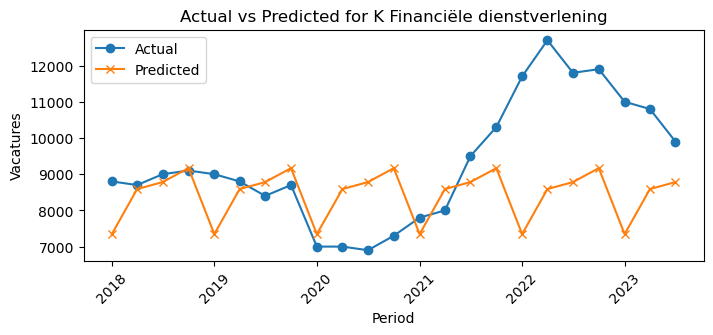

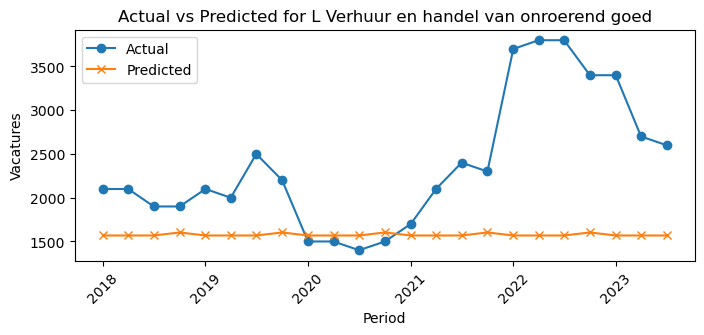

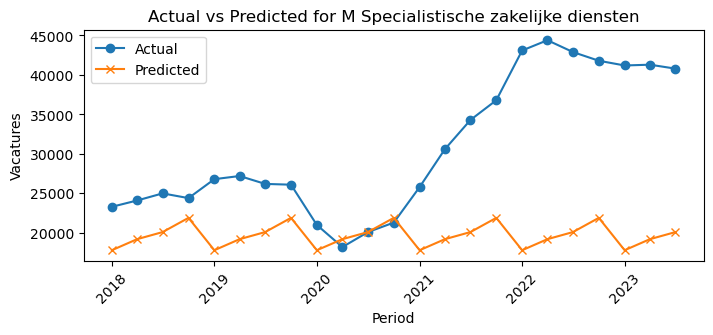

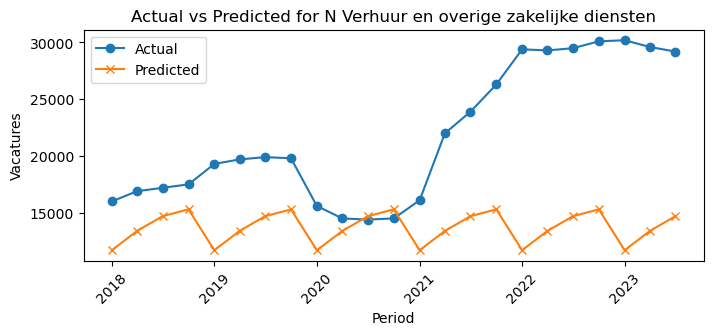

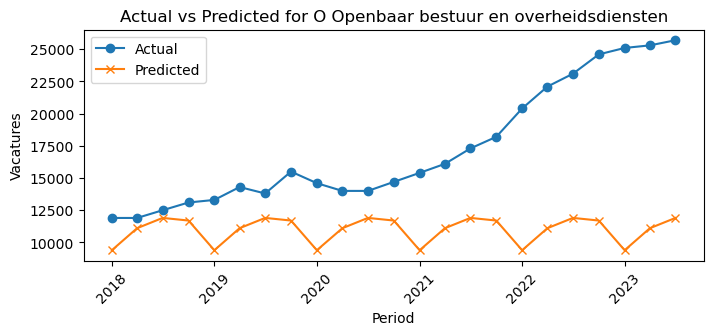

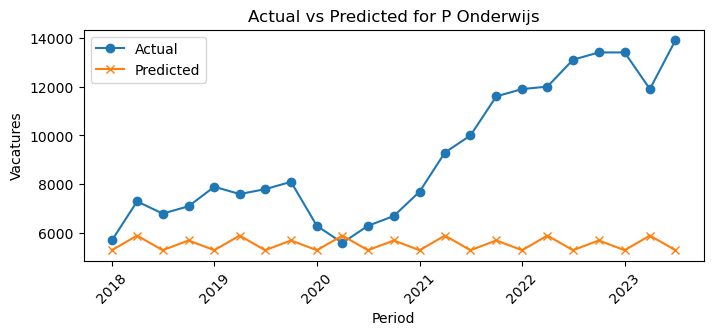

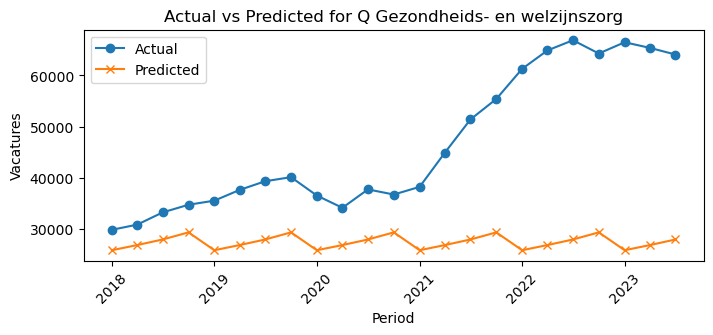

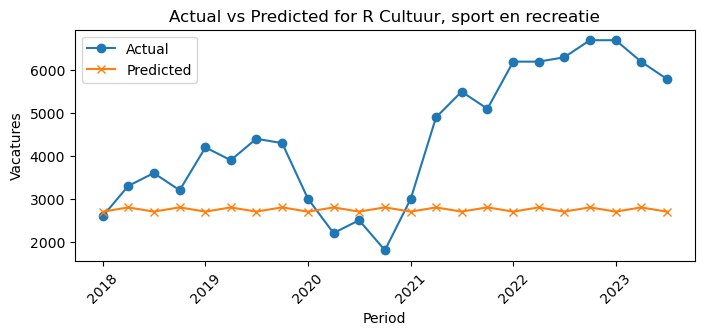

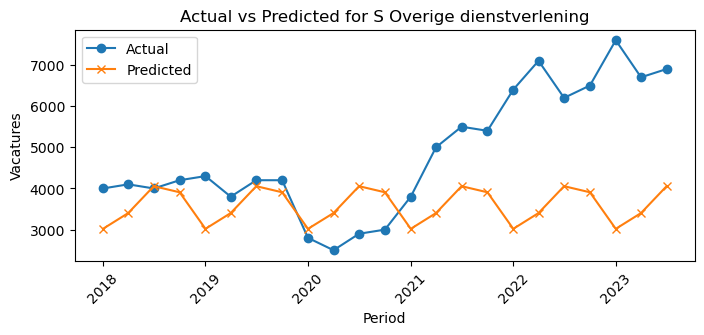

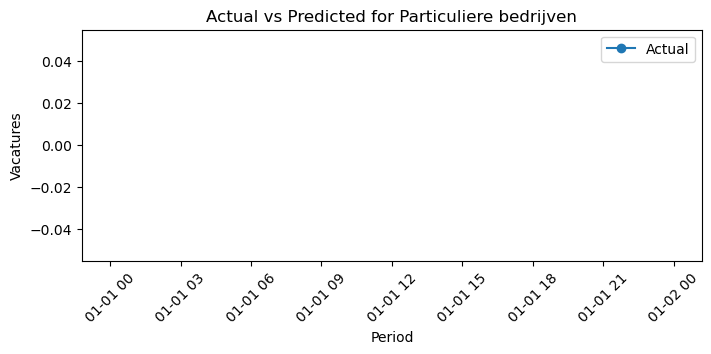

In [11]:
for category, data in category_dataframes.items():
    x_test = data['test'][features]
    y_test = data['test'][target]
    
    predictions = models[category].predict(x_test)
    
    data['test']['Prediction'] = predictions
    
    plt.figure(figsize=(8, 3))
    plt.plot(data['test']['Formatted_Perioden'], y_test, label='Actual', marker='o')
    plt.plot(data['test']['Formatted_Perioden'], predictions, label='Predicted', marker='x')
    
    plt.title(f"Actual vs Predicted for {category}")
    plt.xlabel('Period')
    plt.ylabel('Vacatures')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

##### We could beforehand actually already see that this model would not predict well. Here are some reasons:

1. Limited Temporal Resolution: When your data is aggregated on a yearly or quarterly basis, you're working with a relatively low temporal resolution. This aggregation can mask significant variations that occur within shorter time spans (like months or weeks). For many predictive modeling tasks, especially those involving fast-changing markets or sectors, such finer temporal dynamics are crucial for making accurate predictions.

2. Lack of Feature Diversity: Relying solely on year and quarter for predictions means your model's understanding is constrained to broad temporal trends. It lacks access to potentially influential variables that could significantly affect the outcome, such as economic policies, industry-specific trends, market demand, employment rates, technological advancements, and seasonal hiring patterns. A model's predictive power is often directly tied to the diversity and quality of its features.

3. Seasonality and Trends: While year and quarter data capture some aspects of seasonality and long-term trends, they may not do so with enough granularity or specificity. For example, certain industries might have very specific hiring seasons that are not perfectly aligned with quarters. Additionally, macroeconomic trends can have nuanced impacts within a year that quarterly data cannot fully capture.

4. External Factors: Economic activities like job vacancies are influenced by a wide array of external factors, including but not limited to economic conditions, legislative changes, technological disruptions, and global events (e.g., pandemics or financial crises). A model trained only on years and quarters without consideration of these external factors is likely to miss critical context that affects its predictions.

5. Historical Data Limitations: If the historical data doesn't cover a wide range of economic cycles or unique events, the model may not learn how to generalize well across different economic conditions. This limitation is particularly acute when the data is sparse (i.e., limited to a few data points per year), as is the case with yearly or quarterly data.

6. Predictive Modeling Challenges: Many predictive modeling techniques, especially those used in time series forecasting, rely on identifying patterns in past data to predict future outcomes. When the data is sparse or overly aggregated, it becomes difficult for these models to identify the nuanced patterns necessary for accurate forecasts.